In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import qmc
import torch
import torch.nn as nn
from matplotlib.colors import Normalize

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
file_path = '/kaggle/input/burgers-solution-1000-v0-01/burger_solution_1000_0.01_upwind_scheme.npy' # change it accordingly

In [3]:
with open(file_path, 'rb') as f:
    usol =  np.load(f)

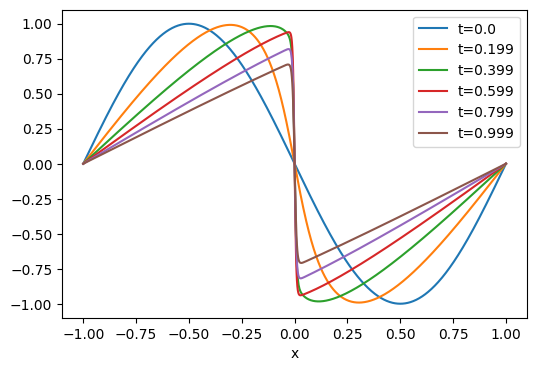

In [4]:
# Visualize some of the data, for some values of t
fig, ax = plt.subplots(1,figsize=(6,4))
for j in [0,199,399,599,799,999]:
    ax.plot(np.linspace(-1, 1, 1000), usol[j,:], label=f't={j/usol.shape[0]}')
ax.set_xlabel('x')
ax.legend()
fig.show()

# the first dimension is t (usol[t,:] is all x at time t)
# second dimension is x 

In [5]:
class ScalingLayer(nn.Module):
    def __init__(self, scale_init_value=1, bias_init_value=0):
        super().__init__()
        self.scale = nn.Parameter(torch.FloatTensor([scale_init_value]))
        self.bias = nn.Parameter(torch.FloatTensor([bias_init_value]))

    def forward(self, input):
        return input * self.scale + self.bias
    
    
class U(nn.Module):
    def __init__(self, in_shape, out_shape, hidden_shapes):
        super().__init__()
        
        self.layers = nn.ModuleList()
        self.layers.append(ScalingLayer())
        for hidden in hidden_shapes:
            self.layers.append(nn.Linear(in_shape, hidden))
            self.layers.append(nn.Sigmoid())
            in_shape = hidden
        self.layers.append(nn.Linear(hidden_shapes[-1], out_shape))
        
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
class F(nn.Module):
    def __init__(self, in_shape, out_shape, hidden_shapes):
        super().__init__()
        
        self.layers = nn.ModuleList()
        self.layers.append(ScalingLayer())
        for hidden in hidden_shapes:
            self.layers.append(nn.Linear(in_shape, hidden))
            self.layers.append(nn.Sigmoid())
            in_shape = hidden
        self.layers.append(nn.Linear(hidden_shapes[-1], out_shape))
        
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

### Get Collocation points

In [6]:
def generate_latin_hyper_c_sampling(Nd=10000):
    sampler = qmc.LatinHypercube(d=2)
    sample_pos = sampler.random(n=Nd//2) # [0,1)^2
    sample_neg = sampler.random(n=Nd//2) # [0,1)^2
    sample_neg[:,1] = -sample_neg[:,1]

    return np.vstack([sample_pos, sample_neg])

In [7]:
collocation_p = generate_latin_hyper_c_sampling(10**4)

In [8]:
collocation_p

array([[ 0.31808777,  0.89582767],
       [ 0.52980426,  0.81250667],
       [ 0.06924935,  0.97278852],
       ...,
       [ 0.20729064, -0.22282117],
       [ 0.9642312 , -0.05495646],
       [ 0.95141356, -0.93083508]])

In [9]:
# first column is in range [0,1] (represents t)
assert collocation_p[:,0].min() > 0
assert collocation_p[:,0].max() < 1

# second column is in range [-1,1] (represents x)
assert collocation_p[:,1].min() > -1
assert collocation_p[:,1].max() < 1

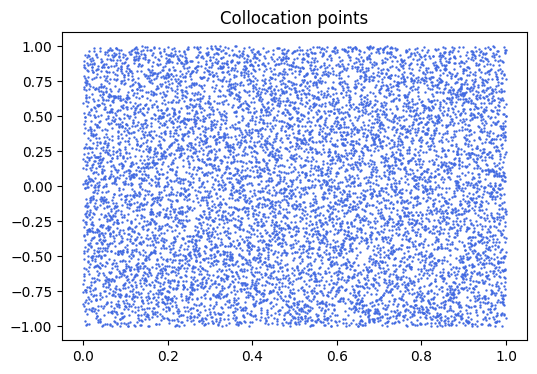

In [10]:
fig, ax = plt.subplots(1,figsize=(6,4))
ax.scatter(collocation_p[:,0], collocation_p[:,1], s=0.5, color='royalblue')
ax.set_title('Collocation points')
fig.show()

### Get training data

In [11]:
def get_train_data(n, t, usol, noise=5e-3):
    t_index = int(t*usol.shape[1])
    
    x_indices = np.arange(0, usol.shape[1], usol.shape[1]//n)
    u_vals = usol[t_index, x_indices]
    u_vals = u_vals.reshape(-1,1)
    
    x_vals = ((x_indices * (2/1000)) -1)
    x_vals = x_vals.reshape(-1,1)
    t_vals = np.array([t]*x_vals.shape[0])
    t_vals = t_vals.reshape(-1,1)
    
    # INPUT: [[0,x1],[0,x2], [0,x3]...[0,x_n]], TARGET = u_vals
    
    u_vals += (np.random.normal(loc=0.0, scale=1.0, size=u_vals.shape[0]) * noise).reshape(-1,1)
    
    return np.concatenate([t_vals, x_vals], axis=1), u_vals

In [12]:
train_data_t05, target_t05 = get_train_data(100, 0.5, usol, noise=5e-3)
train_data_t0, target_t0 = get_train_data(100, 0, usol, noise=5e-3)

train_data = np.concatenate([train_data_t05, train_data_t0], axis=0)
train_targets = np.concatenate([target_t05, target_t0], axis=0)

# print(train_data.shape)
# print(train_targets.shape)

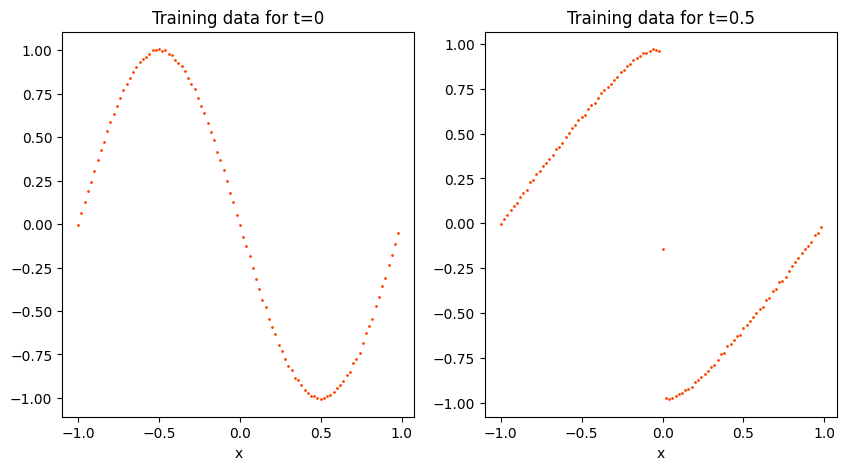

In [13]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].scatter(train_data_t0[:,1], target_t0[:,0], s=1, color='orangered')
ax[0].set_title('Training data for t=0')
ax[0].set_xlabel('x')
ax[1].scatter(train_data_t05[:,1], target_t05[:,0], s=1, color='orangered')
ax[1].set_title('Training data for t=0.5')
ax[1].set_xlabel('x')
fig.show()

In [14]:
def get_boundary_points(n=100):
    sampler = qmc.LatinHypercube(d=1)
    sample_pos = sampler.random(4*n)
    
    u_initial = lambda x: -np.sin(np.pi * x)
    
    top_b = sample_pos[:100]
    top_b = np.concatenate([top_b, np.ones_like(top_b)],axis=1)
    top_b_target = np.zeros((top_b.shape[0],1))

    bot_b = sample_pos[100:200]
    bot_b = np.concatenate([bot_b, np.ones_like(bot_b)*-1],axis=1)
    bot_b_target = np.zeros((bot_b.shape[0],1))
    
    x_b = sample_pos[200:300]
    x_b = np.concatenate([np.zeros_like(x_b), x_b],axis=1)
    x_b_target = u_initial(x_b[:,1]).reshape(-1,1)

    
    negx_b = -sample_pos[300:]
    negx_b = np.concatenate([np.zeros_like(negx_b), negx_b],axis=1)
    negx_b_target = u_initial(negx_b[:,1]).reshape(-1,1)
    
    return np.concatenate([top_b, bot_b, x_b, negx_b],axis=0), np.concatenate([top_b_target, 
                                                                               bot_b_target, 
                                                                               x_b_target, 
                                                                              negx_b_target], axis=0)

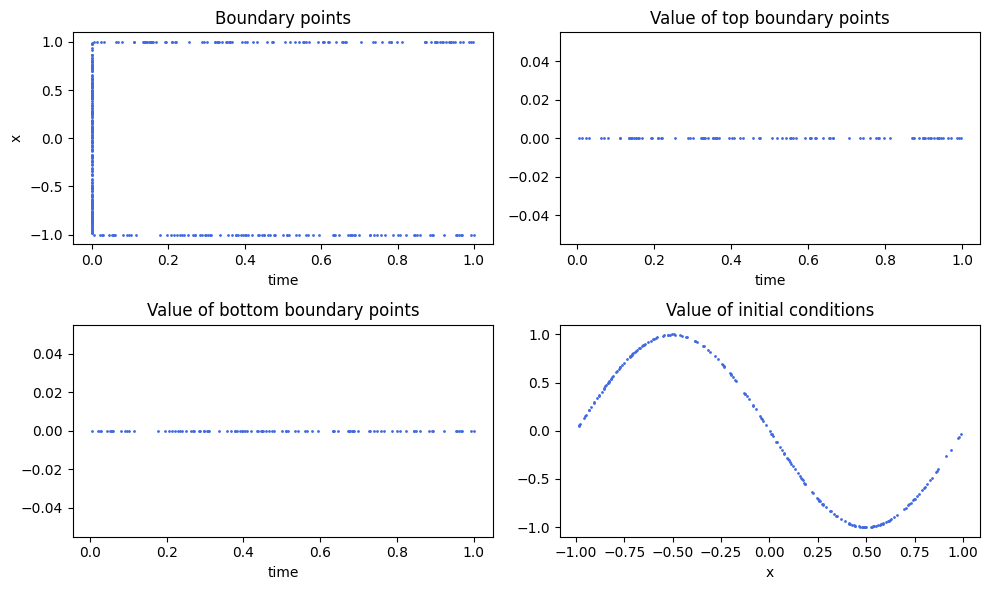

In [15]:
fig, ax = plt.subplots(2,2, figsize=(10,6))

boundary_points, boundary_targets = get_boundary_points(100)

ax[0,0].scatter(boundary_points[:,0], boundary_points[:,1], s=1.0, color='royalblue')
ax[0,0].set_title('Boundary points')
ax[0,0].set_xlabel('time')
ax[0,0].set_ylabel('x')

ax[0,1].scatter(boundary_points[:100,0], boundary_targets[:100], s=1.0, color='royalblue')
ax[0,1].set_title('Value of top boundary points')
ax[0,1].set_xlabel('time')

ax[1,0].scatter(boundary_points[100:200,0], boundary_targets[100:200], s=1.0, color='royalblue')
ax[1,0].set_title('Value of bottom boundary points')
ax[1,0].set_xlabel('time')

ax[1,1].scatter(boundary_points[200:,1], boundary_targets[200:], s=1.0, color='royalblue')
ax[1,1].set_title('Value of initial conditions')
ax[1,1].set_xlabel('x')

fig.tight_layout()

### Training

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

# put data on device
collocation_p = torch.Tensor(collocation_p).to(device).requires_grad_(True)
boundary_points = torch.Tensor(boundary_points).to(device)
boundary_targets = torch.Tensor(boundary_targets).to(device)
train_data = torch.Tensor(train_data).to(device)
train_targets = torch.Tensor(train_targets).to(device)

In [36]:
u = U(2,1, [20]*8)
u = u.to(device)

f = F(3,1, [20]*8)
f = f.to(device)

Boundary L: 1.1992374311375897e-05, Phys L: 1.8972912585013546e-05, Data L: 0.0005468723247759044


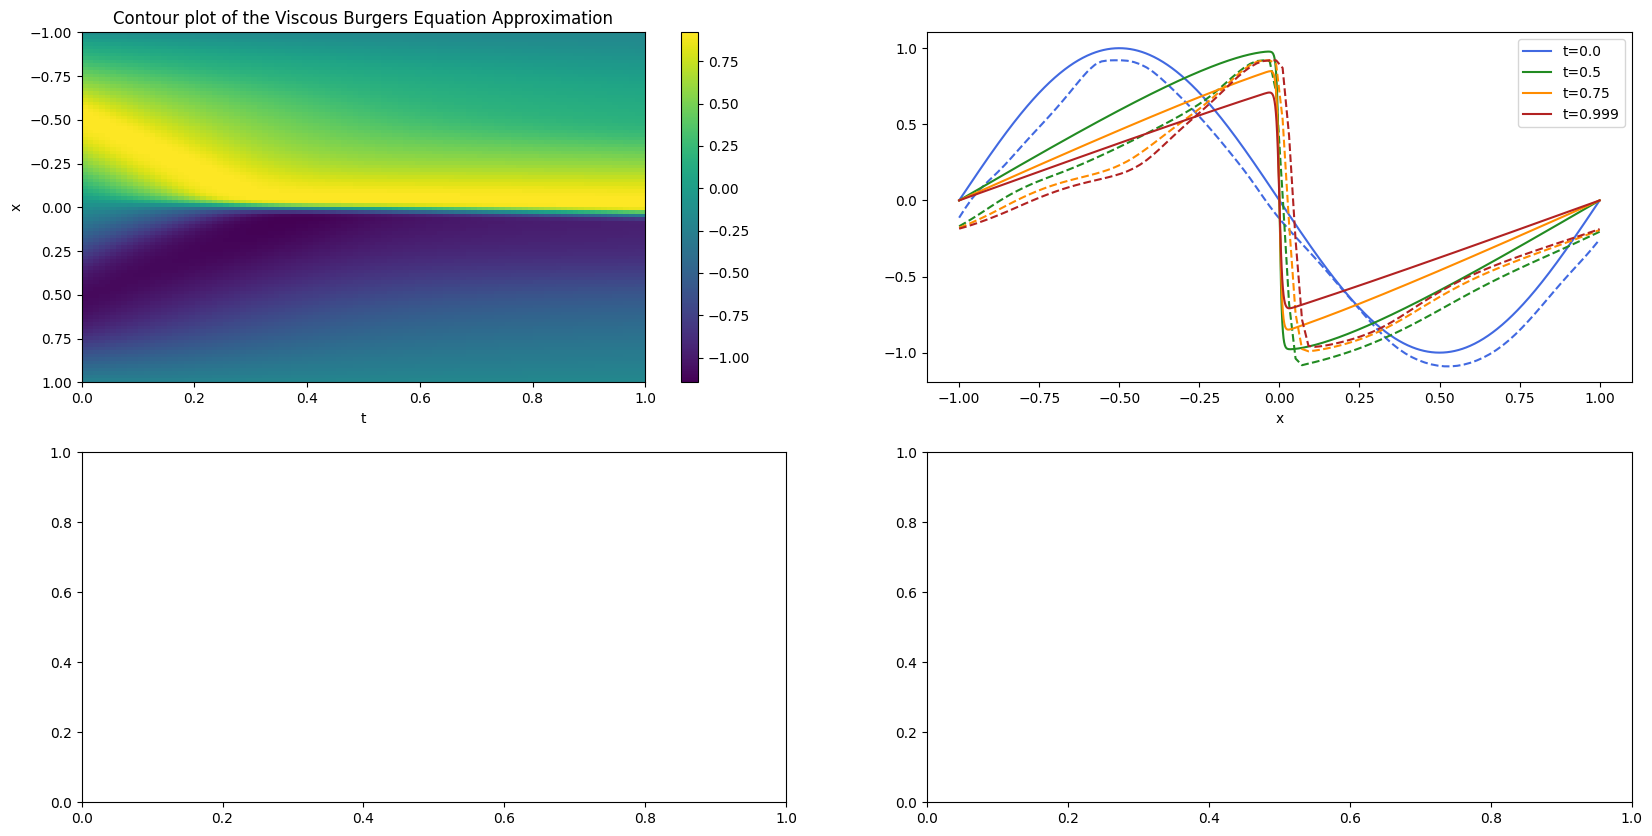

Boundary L: 0.00026635665562935174, Phys L: 7.833072595531121e-05, Data L: 0.0012850627535954118


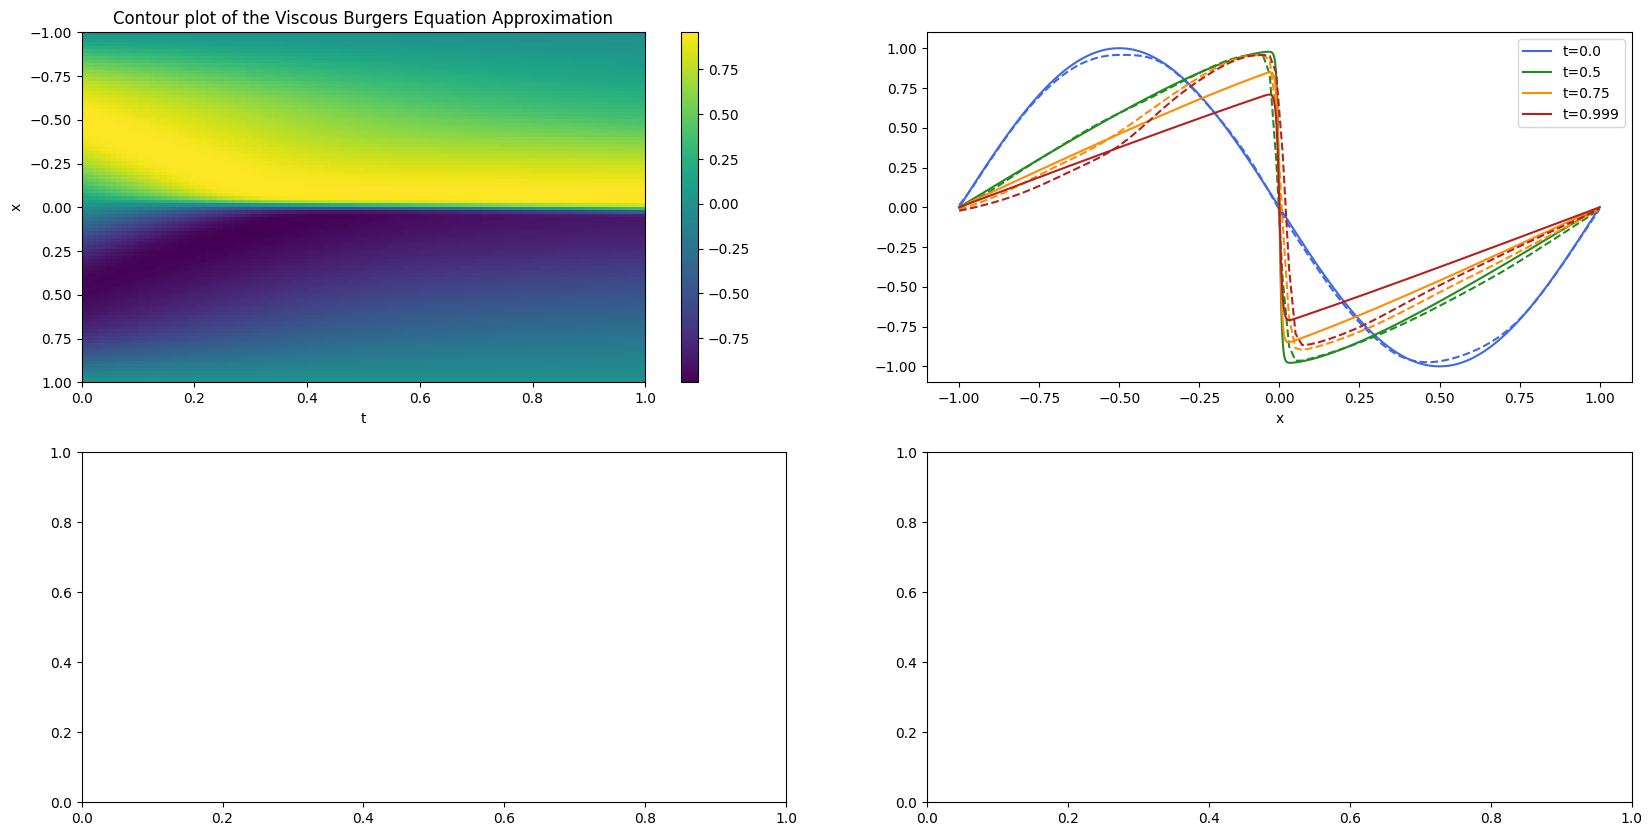

Boundary L: 5.413676626631059e-05, Phys L: 4.2904128349618986e-05, Data L: 0.0010957008926197886


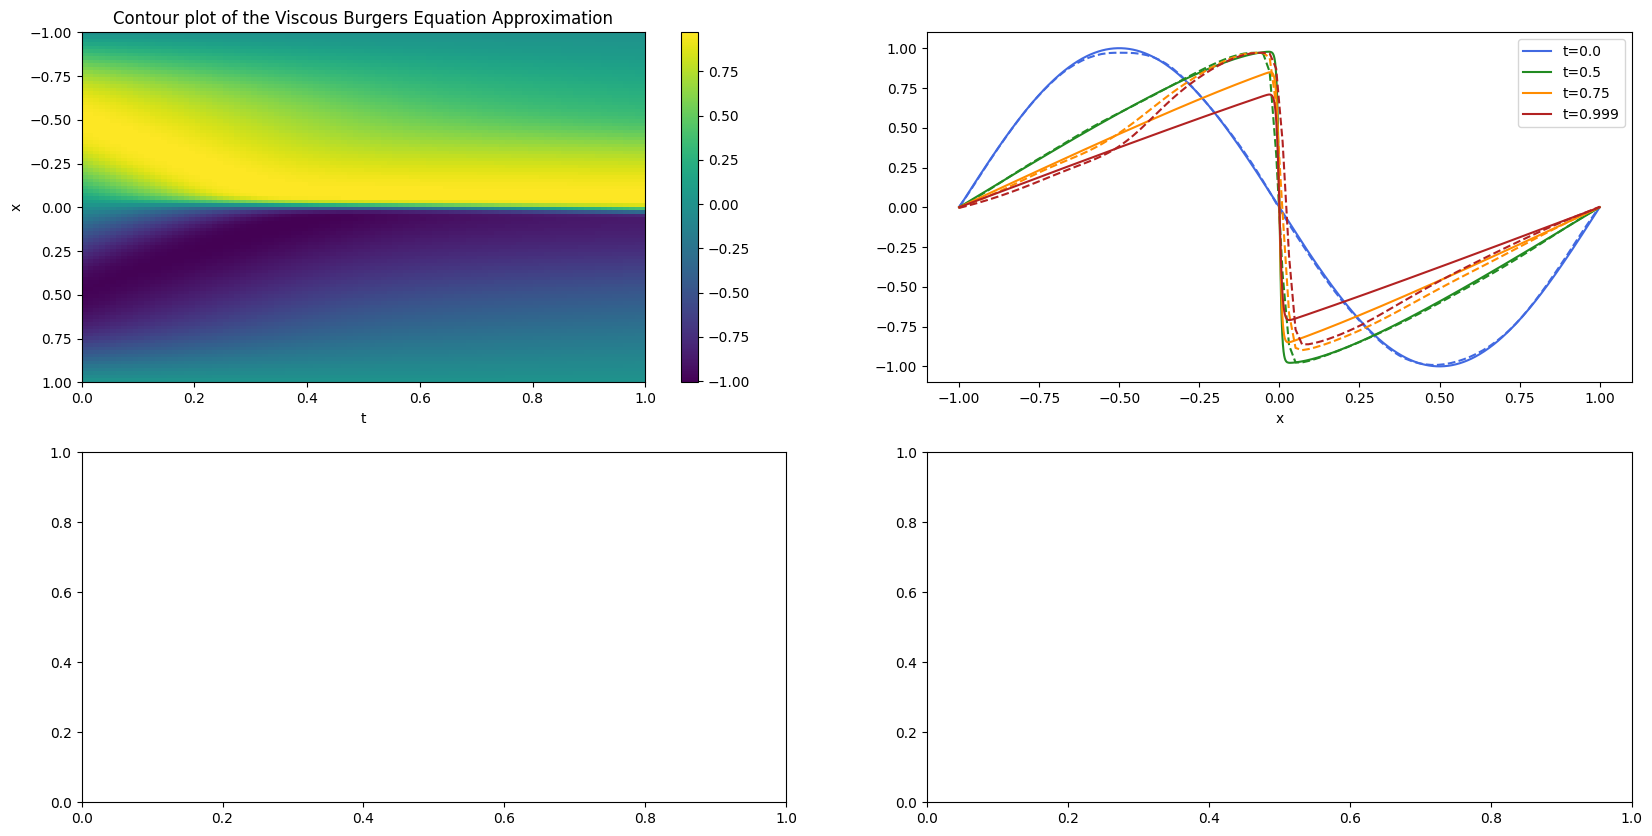

Boundary L: 3.506992288748734e-05, Phys L: 2.6944044293486513e-05, Data L: 0.0012139577884227037


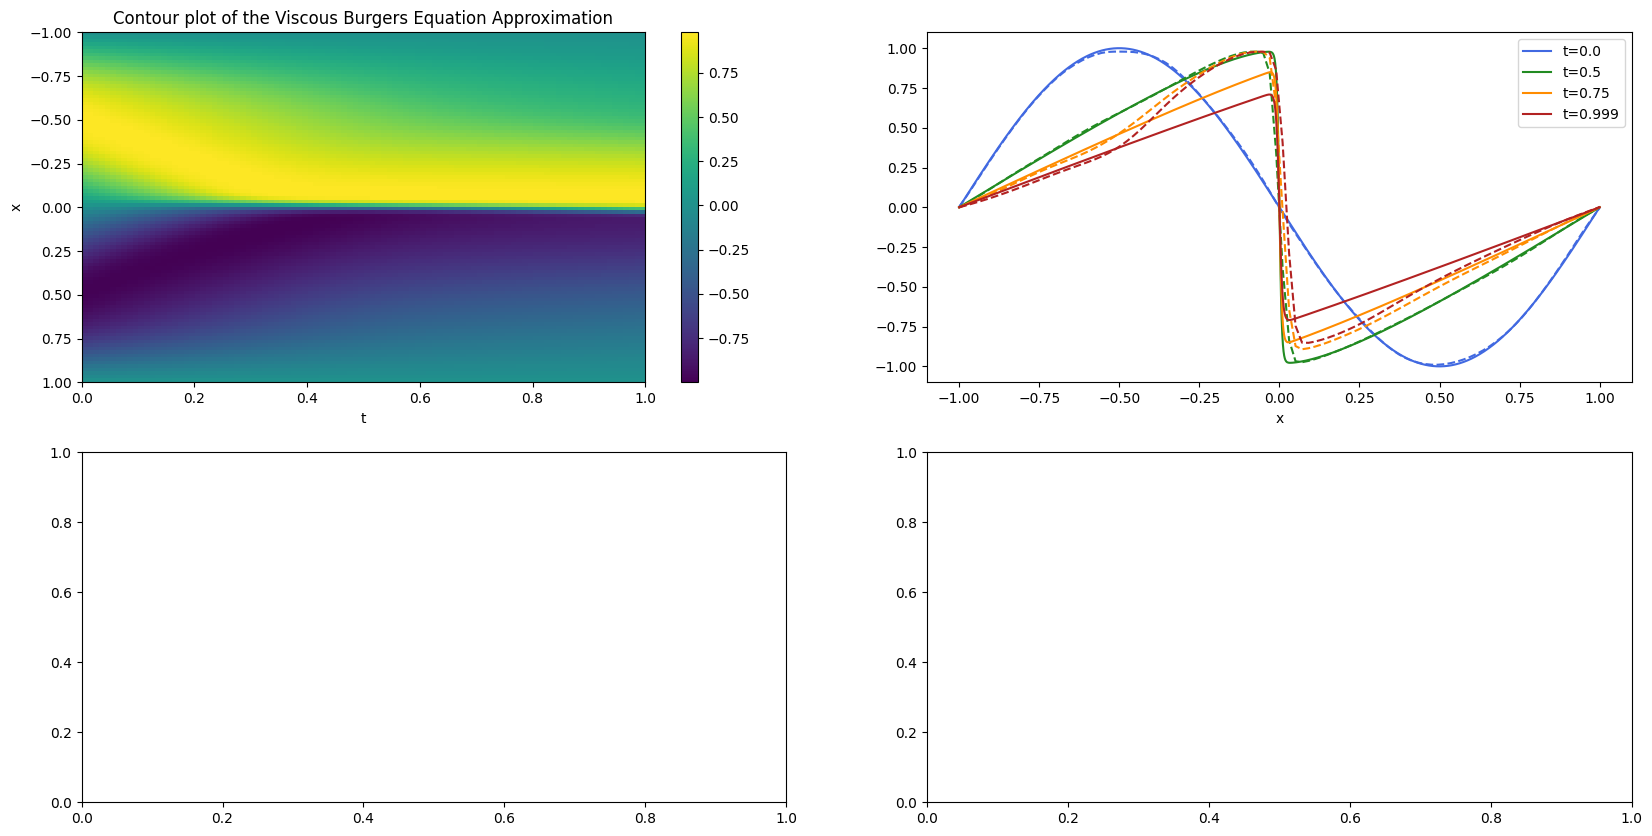

Boundary L: 5.0425434892531484e-05, Phys L: 2.7003705326933414e-05, Data L: 0.0013835312565788627


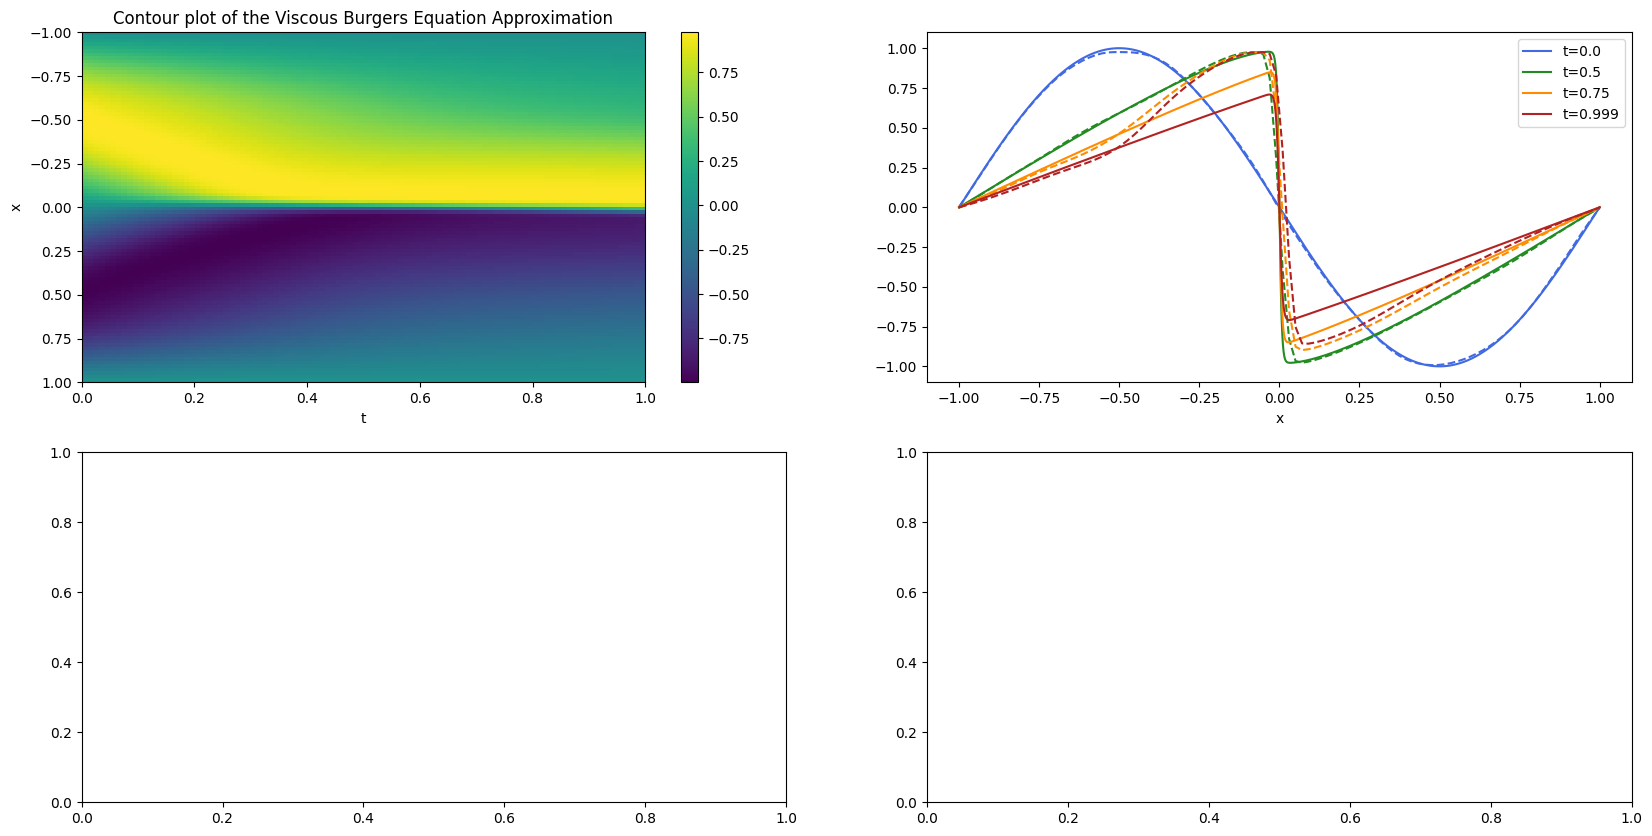

Boundary L: 8.928041643230245e-05, Phys L: 5.964309457340278e-05, Data L: 0.0015805321745574474


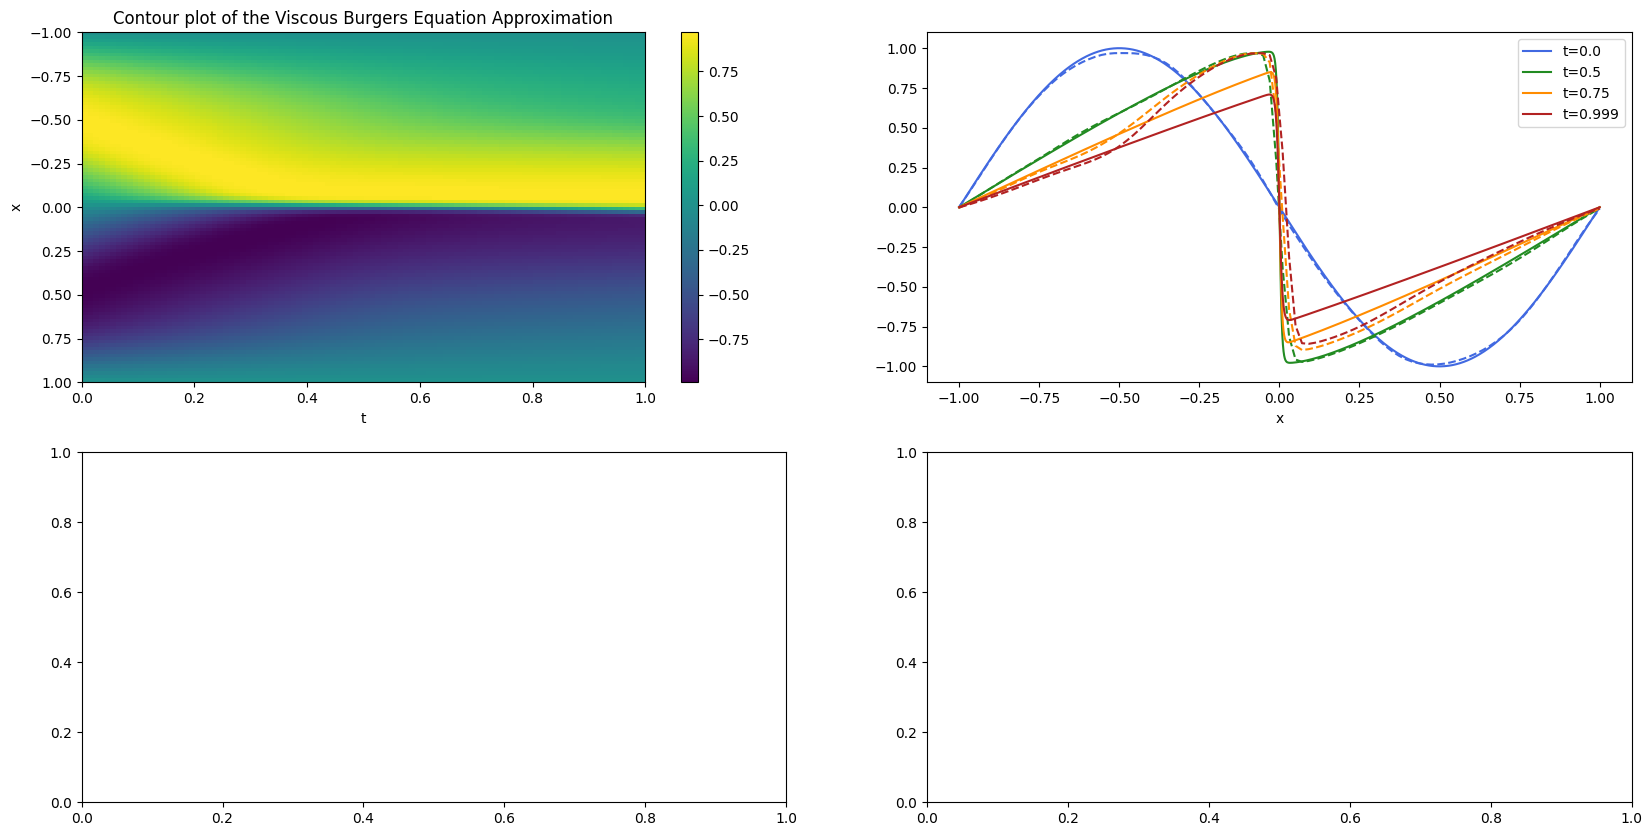

Boundary L: 0.00010738372657215223, Phys L: 3.421655128477141e-05, Data L: 0.0028099033515900373


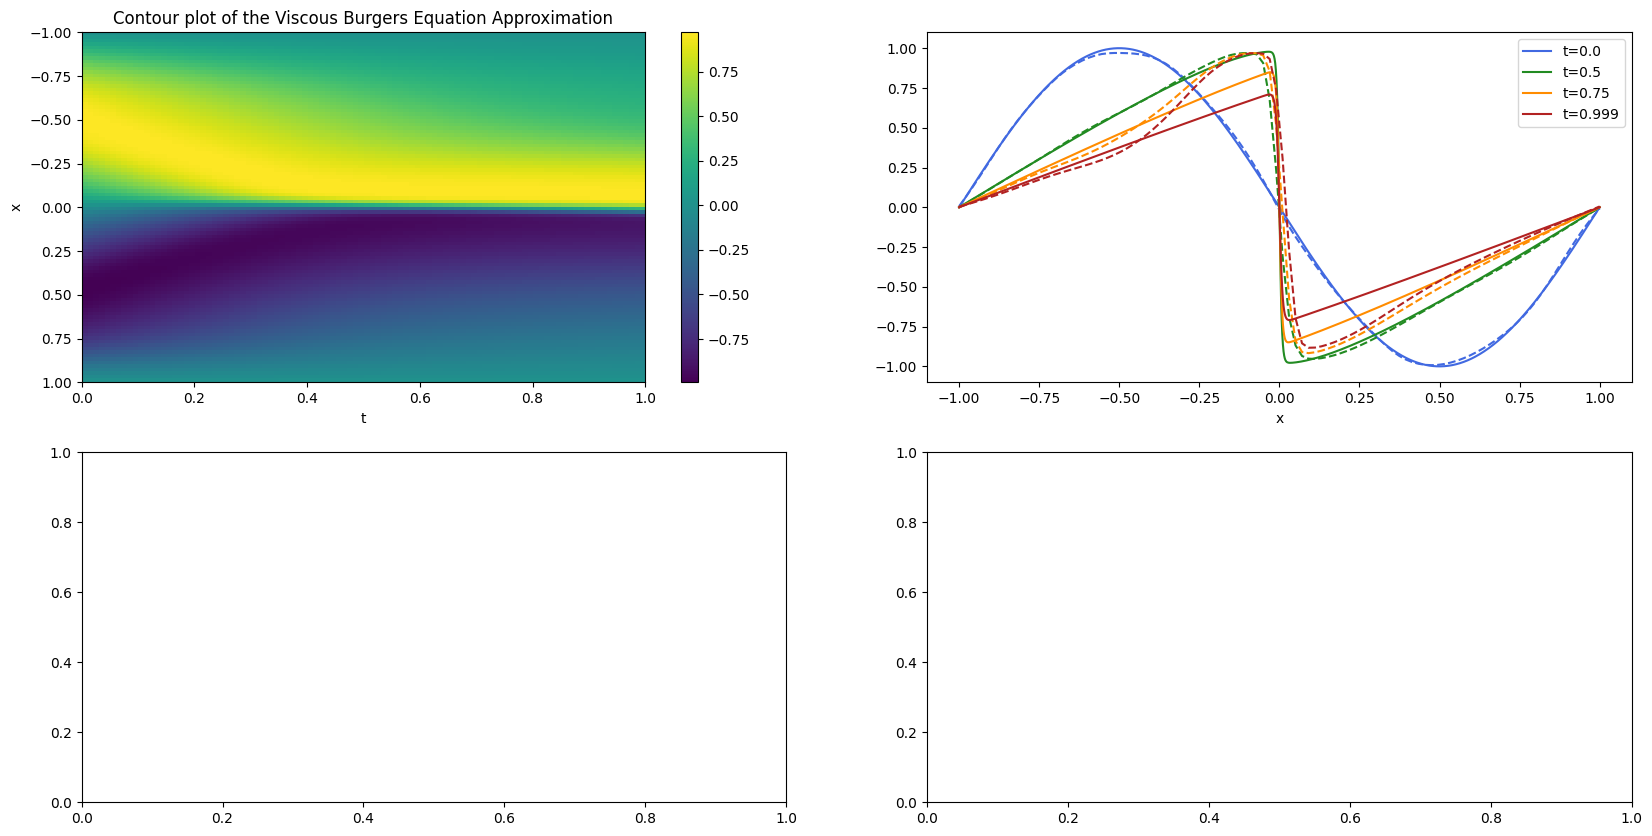

Boundary L: 3.877280687447637e-05, Phys L: 2.1416233721538447e-05, Data L: 0.0019473785068839788


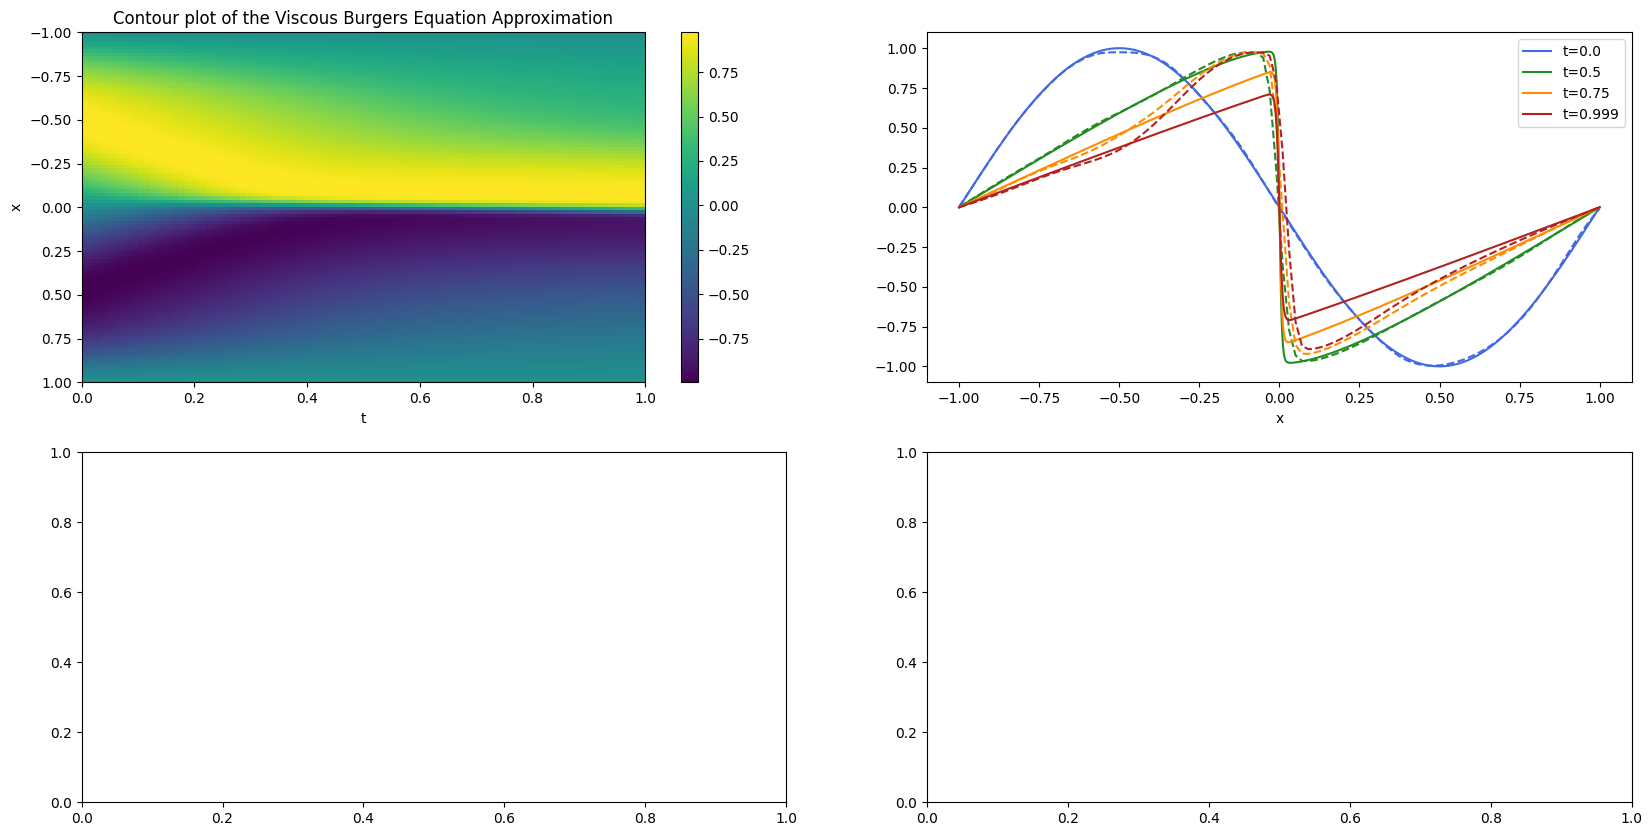

Boundary L: 0.00028271254268474877, Phys L: 0.0005899055977351964, Data L: 0.0022712002974003553


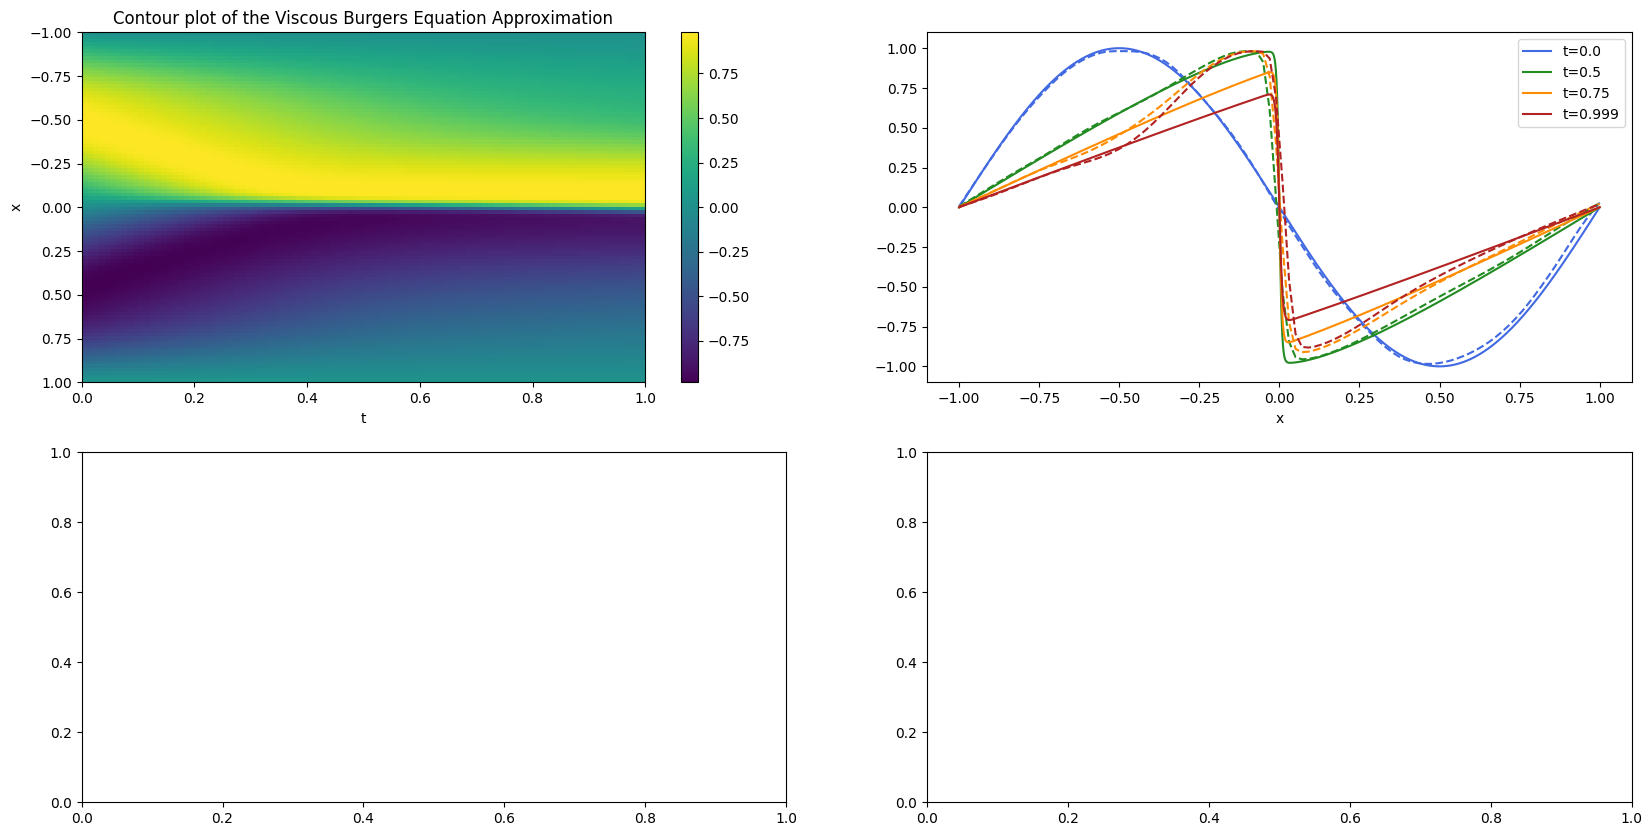

KeyboardInterrupt: 

In [40]:
lr = 2e-2
optimizer = torch.optim.Adam([*u.parameters(), *f.parameters()], lr=lr)
lambda1, lambda2, lambda3 = 1e1, 5e1, 1e1

phys_losses = []
losses = []

total_itr = 50001



for i in range(total_itr):
    optimizer.zero_grad()
    
    # boundary loss -------
    u_b = u(boundary_points)
    loss1 = nn.MSELoss()(u_b, boundary_targets)
    

    # Physics loss -------
    u_p = u(collocation_p)
    # retain graph?
    dudxt = torch.autograd.grad(u_p, collocation_p, torch.ones_like(u_p), create_graph=True)[0]
    dudt = dudxt[:,0]
    dudx = dudxt[:,1]
    
#     print(dudx.shape)
#     print(collocation_p[:,1].shape)
    du2dx2 = torch.autograd.grad(dudxt, collocation_p, 
                                 torch.ones_like(dudxt), create_graph=True)[0][:,1]
    
    f_input = torch.cat([u_p,dudt.reshape(-1,1),dudx.reshape(-1,1)], axis=1)
    f_p = f(f_input)
    
#     print(dudt.shape)
#     print(u_p.shape)
#     print(du2dx2.shape)
    
    v = 1 / (100 * np.pi)
    # TODO check loss size
    # TODO use f
    loss2 = nn.MSELoss()(-dudt.reshape(-1,1) - f_p + v * du2dx2.reshape(-1,1), torch.zeros_like(dudt.reshape(-1,1)))
    
    # Datapoint loss -------
    u_n = u(train_data)
    loss3 = nn.MSELoss()(u_n, train_targets)
    
    loss = lambda1*loss1 + lambda2*loss2  + lambda3*loss3
    
#     phys_losses.append(loss2.item())
    losses.append(loss.item())
    
    loss.backward()
    optimizer.step()
    
#     sys.stdout.write("\r[%-20s] %d%%" % ('=' * (i // (total_itr // 20)), (i * 100) // total_itr))
#     sys.stdout.flush()
    
    if i% 1000 == 0:
        with torch.no_grad():
            print(f'Boundary L: {loss1.item()}, Phys L: {loss2.item()}, Data L: {loss3.item()}')

            t_phys = np.linspace(0, 1, 10**2)
            x_phys = np.linspace(-1, 1, 10**2)
            x_mesh, t_mesh = np.meshgrid(x_phys, t_phys)

            coordinates = np.vstack((t_mesh.flatten(), x_mesh.flatten())).T
            coordinates = torch.Tensor(coordinates).to(device)
            
            u_p = u(coordinates).detach().cpu().numpy()
            u_mesh = u_p.reshape(x_mesh.shape)

            data_min = np.min(u_p)
            data_max = np.max(u_p)

    #         X = collocation_p[1].detach().numpy()
    #         T = collocation_p[0].detach().numpy()

            # Contour plot
            fig, ax = plt.subplots(2,2,figsize=(20,10))
            norm = Normalize(vmin=data_min, vmax=data_max)
#             contour = ax[0,0].contourf(x_mesh, t_mesh, u_mesh.T, 50, cmap='viridis', norm=norm)
            img = ax[0,0].imshow(u_mesh.T, cmap='viridis', aspect='auto', extent=[0, 1, 1, -1])  # 'viridis' is just one of the available color maps
            fig.colorbar(img, ax=ax[0,0])
    
#             fig.colorbar(contour, ax=ax[0,0])

            ax[0,0].set_xlabel('t')
            ax[0,0].set_ylabel('x')
            ax[0,0].set_title('Contour plot of the Viscous Burgers Equation Approximation')
            
            # Slices
            
            # Visualize some of the data, for some values of t
            colors = ['royalblue', 'forestgreen', 'darkorange', 'firebrick']
            for i,(j,k) in enumerate(zip([0,500,750,999], [0,50,75,99])):
                ax[0,1].plot(np.linspace(-1, 1, 1000), usol[j,:], 
                             label=f't={j/usol.shape[0]}', color=colors[i])
                ax[0,1].plot(np.linspace(-1, 1, 100), 
                             u_mesh[k,:], linestyle='--', color=colors[i])
            ax[0,1].set_xlabel('x')
            ax[0,1].legend()
            fig.show()

            plt.show()
